In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from torch.utils.data import Dataset, DataLoader
from utils.prepare_data import prepare_input
from utils.class_loss import MVELoss
from utils.evaluate import evaluate,evaluate_output
from model.class_GCN import GCN_LSTM

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/processed/processed_data.csv')
zone_id = df['zone'].unique()

### Predicted mean and std

In [94]:
# Define hyperparameters
n_features = 2
n_stations = 63
hid_g = 64
hid_fc = 64
hid_l = 64
meanonly = False
homo = 0
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.001
dropout = 0.2
num_epochs = 20
nadj = ['euc','con','func']
dist = 'norm'
z = 0.95

# Define other parameters
SAVEPATH = "weights/model_norm_full.pt"
filepath = 'data/processed/0627.npz'
adjfile = 'data/processed/adjlist.csv'

In [95]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Define the loss function
loss_fn = MVELoss(dist)

# load model
checkpoint = torch.load(SAVEPATH,map_location=device)
trained_model = GCN_LSTM(n_features,n_stations,hid_g,hid_fc,hid_l,meanonly,homo,nadj,device,dropout)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

GCN_LSTM(
  (batchnorm): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn): GCNLayer(
    (gc1): GCNConv(2, 64)
    (gc2): GCNConv(64, 64)
  )
  (fc1): Linear(in_features=4032, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (lstm): LSTM(64, 64)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (final): Linear(in_features=64, out_features=126, bias=True)
  (recent_on_history_mean): Linear(in_features=64, out_features=63, bias=True)
  (recent_on_history_var): Linear(in_features=64, out_features=63, bias=True)
)

In [96]:
# Read in and prepare dataset
data = data = np.load(filepath)
x = data['x']
y = data['y']
adj = pd.read_csv(adjfile)
history = data['history']
weather = data['weather']
los = data['los']

_,_,test_loader,adj_torch = prepare_input(x,y,adj,nadj,history,weather,los,device,batch_size=batch_size,train=0,val=0,test=1)

In [97]:
trained_model.eval()
eval_loss = 0
eval_num = len(test_loader.dataset)
for i,evaldata in enumerate(test_loader):
    batch_x, batch_y, batch_history, batch_weather, batch_los = evaldata

    batch_x = batch_x.float()
    batch_y = torch.squeeze(batch_y).float()
    batch_history = batch_history.float()

    batch_x, batch_y, batch_history, batch_weather, batch_los = \
        batch_x.to(device), batch_y.to(device), batch_history.to(device), \
        batch_weather.to(device), batch_los.to(device)

    outputs = trained_model(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)
    if outputs.shape[0]!=2*batch_size:
        batch_new = int((outputs.shape[0])/2)
        output_loc = outputs[:batch_new,:]
        output_scale = outputs[batch_new:,:]
    else:
        output_loc = outputs[:batch_size,:]
        output_scale = outputs[batch_size:,:]
    loss = loss_fn(output_loc, output_scale, batch_y)

    loss = loss_fn(output_loc, output_scale, batch_y)
    eval_loss += loss.item()

    # Get mean and variance
    if i == 0:
        test_out_mean = outputs[:batch_size,:].cpu().detach().numpy()
        test_out_var = outputs[batch_size:,:].cpu().detach().numpy()
        y_eval = batch_y.cpu().numpy()
    else:
        if outputs.shape[0]==2*batch_size:
            test_out_mean = np.concatenate((test_out_mean, outputs[:batch_size,:].cpu().detach().numpy()), axis=0)
            test_out_var = np.concatenate((test_out_var, outputs[batch_size:,:].cpu().detach().numpy()), axis=0)
            y_eval = np.concatenate((y_eval, batch_y.cpu().numpy()), axis=0)
        else:
            batch_new = int((outputs.shape[0])/2)
            test_out_mean = np.concatenate((test_out_mean, outputs[:batch_new,:].cpu().detach().numpy()), axis=0)
            test_out_var = np.concatenate((test_out_var, outputs[batch_new:,:].cpu().detach().numpy()), axis=0)
            y_eval = np.concatenate((y_eval, batch_y.cpu().numpy()), axis=0)

In [114]:
print('Testing ...')
loss, mae, mape, mpiw, picp = evaluate(trained_model, loss_fn, adj_torch, dist, test_loader, z, device, batch_size)
print('Average loss;', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Testing ...
Average loss; 156.63587273491754 | MAE: 2.6978442668914795 | MAPE: 0.21873630583286285 | MPIW 15.070559088485352 | PICP: 0.9636243386243386


In [99]:
# Output to optimization input format
bins = np.arange(0,288)

mean = test_out_mean.flatten('F')
var = test_out_var.flatten('F')
zone_column = np.repeat(zone_id,288)
bin_column = np.tile(bins,63)

df_mean = pd.DataFrame({"zone":zone_column,"bin":bin_column,"demand":mean})
df_std = pd.DataFrame({"zone":zone_column,"bin":bin_column,"demand":var})

df_mean.to_csv('data/result/0628_mean.csv',index=False)
df_std.to_csv('data/result/0628_std.csv',index=False)

In [107]:
# df_mean = pd.read_csv('data/result/0628_mean.csv')
# df_std = pd.read_csv('data/result/0628_std.csv')

predicted_mean = df_mean.pivot(index='zone',columns='bin',values='demand').values
predicted_std = df_std.pivot(index='zone',columns='bin',values='demand').values

### Historical mean and std

In [108]:
# Get historical mean and std
prev_data = df[(df['month']!=6)|(df['day']<27)]
prev_group = prev_data.groupby(by=['month','day'])

n = len(df['zone'].unique())
K = len(df['bin'].unique())
m = len(prev_group)

data_points = np.zeros((n,K,m))
i = 0
for _,df_day in prev_group:
    y_i = df_day[['zone','bin','demand']].pivot(index='zone',columns='bin',values='demand')
    data_points[:,:,i] = y_i.values
    i+=1


In [109]:
historical_mean = np.mean(data_points,axis=2)
historical_std = np.std(data_points,axis=2)

### Compare

In [110]:
# Mean and std
predicted_mean = torch.from_numpy(predicted_mean)
predicted_std = torch.from_numpy(predicted_std)
historical_mean = torch.from_numpy(historical_mean)
historical_std = torch.from_numpy(historical_std)
historical_std[historical_std==0] = 1e-5

In [111]:
# True demand
June_27_data = df[(df['month']==6)&(df['day']==27)]
true_demand = June_27_data[['zone','bin','demand']].pivot(index='zone',columns='bin',values='demand').values
true_demand = torch.from_numpy(true_demand)

In [112]:
loss, mae, mape, mpiw, picp = evaluate_output(predicted_mean, predicted_std, true_demand, loss_fn, dist, z)
print('Average loss:', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Average loss: 156.63587355683666 | MAE: 2.6978442668914795 | MAPE: 0.21873630583286285 | MPIW 15.070559088485352 | PICP: 0.9636243386243386


In [113]:
loss, mae, mape, mpiw, picp = evaluate_output(historical_mean, historical_std, true_demand, loss_fn, dist, z)
print('Average loss:', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Average loss: 138889048.4339748 | MAE: 2.8724002838134766 | MAPE: 0.23288898169994354 | MPIW 14.778458924058373 | PICP: 0.9349096119929453


### Error distribution

In [11]:
def loss_separate(output_loc, output_scale, target, dist):
        loc = torch.flatten(output_loc)
        if output_scale is not None:
            scale = torch.flatten(output_scale)
        t = torch.flatten(target)

        if dist == 'laplace':
            d = torch.distributions.laplace.Laplace(loc, scale)
            loss = d.log_prob(t)

        elif dist == 'tnorm':
            d = torch.distributions.normal.Normal(loc, scale)
            prob0 = d.cdf(torch.Tensor([0]).to(target.device))
            loss = d.log_prob(t) - torch.log(1-prob0)

        elif dist == 'lognorm':
            d = torch.distributions.log_normal.LogNormal(loc, scale)
            loss = d.log_prob(t+0.000001)

        elif dist == 'poisson':
            d = torch.distributions.poisson.Poisson(loc)
            loss = d.log_prob(t)

        elif (dist == 'norm') | (dist == 'norm_homo'):
            d = torch.distributions.normal.Normal(loc, scale)
            loss = d.log_prob(t)

        elif dist == 'nb':

            def nb_nll_loss(y,n,p):
                """
                y: true values
                y_mask: whether missing mask is given
                """
                nll = torch.lgamma(n) + torch.lgamma(y+1) - torch.lgamma(n+y) - n*torch.log(p) - y*torch.log(1-p)
                return torch.sum(nll)

            loss = nb_nll_loss(t, loc, scale) # check scale constraints

        else:
            print("Dist error")
            return 0


        return -torch.reshape(loss,(target.shape[0],target.shape[1]))

In [12]:
historical = loss_separate(historical_mean, historical_std, true_demand, dist)

In [14]:
historical[historical>1e6] = 5

In [15]:
time_series = torch.mean(historical,0)

fig = px.line(x=list(range(1,289)), y=time_series)
fig.update_layout(
    xaxis_title="Time", yaxis_title="Error"
)
fig.show()

In [37]:
station_series = torch.mean(historical,1)
fig = go.Figure(data=go.Scatter(x=list(range(1,64)), y=station_series, mode='markers'))

fig.update_layout(
    xaxis_title="Station", yaxis_title="Error"
)
fig.show()

In [38]:
import numpy as np
import plotly.graph_objects as go

# Assuming your matrix is named 'service_level_matrix'
# Shape: (63, 24)

# Generate x and y coordinates for each station and time interval
x = np.arange(1,25)
y = np.arange(1,64)

# Create a meshgrid of x and y coordinates
X, Y = np.meshgrid(x, y)

# Create the heatmap trace
heatmap = go.Heatmap(
    x=x,
    y=y,
    z=historical,
    colorscale='Viridis'  # Use a colorscale of your choice
)

# Create the layout
layout = go.Layout(
    title='Space-Temporal Distribution of Error',
    xaxis=dict(title='Time Interval'),
    yaxis=dict(title='Station'),
    height=800,
    width=800,
)

# Create the figure
fig = go.Figure(data=[heatmap], layout=layout)

# Show the figure
fig.show()

In [33]:
historical_mean[25,72]

tensor(0., dtype=torch.float64)

In [32]:
historical_std[25,72]

tensor(1.0000e-05, dtype=torch.float64)

In [31]:
true_demand[25,72]

tensor(1., dtype=torch.float64)

In [34]:
zone_id[25]

128

In [50]:
predicted = loss_separate(predicted_mean, predicted_std, true_demand, dist)

In [51]:
time_series = torch.mean(predicted,0)

fig = px.line(x=list(range(1,289)), y=time_series)
fig.update_layout(
    xaxis_title="Time", yaxis_title="Error"
)
fig.show()

In [52]:
station_series = torch.mean(predicted,1)
fig = go.Figure(data=go.Scatter(x=list(range(1,64)), y=station_series, mode='markers'))

fig.update_layout(
    xaxis_title="Station", yaxis_title="Error"
)
fig.show()

In [53]:
import numpy as np
import plotly.graph_objects as go

# Assuming your matrix is named 'service_level_matrix'
# Shape: (63, 24)

# Generate x and y coordinates for each station and time interval
x = np.arange(1,25)
y = np.arange(1,64)

# Create a meshgrid of x and y coordinates
X, Y = np.meshgrid(x, y)

# Create the heatmap trace
heatmap = go.Heatmap(
    x=x,
    y=y,
    z=predicted,
    colorscale='Viridis'  # Use a colorscale of your choice
)

# Create the layout
layout = go.Layout(
    title='Space-Temporal Distribution of Error',
    xaxis=dict(title='Time Interval'),
    yaxis=dict(title='Station'),
    height=800,
    width=800,
)

# Create the figure
fig = go.Figure(data=[heatmap], layout=layout)

# Show the figure
fig.show()

In [41]:
predicted_mean[22,37]

tensor(0.0449, dtype=torch.float64)

In [42]:
predicted_std[22,37]

tensor(0.1803, dtype=torch.float64)

In [55]:
zone_id[31]

144

<Axes: >

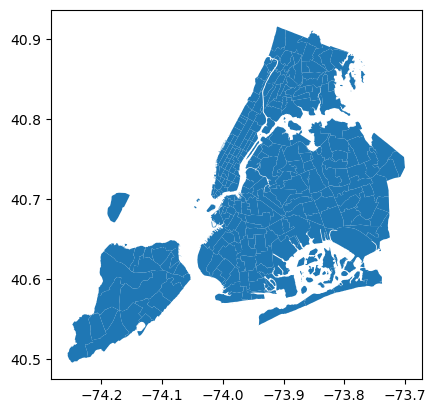

In [56]:
zipfile = 'data/taxi_zones.shp'
zones = gpd.read_file(zipfile)
zones_wgs84 = zones.to_crs('EPSG:4326')
zones_wgs84.plot()

<Axes: >

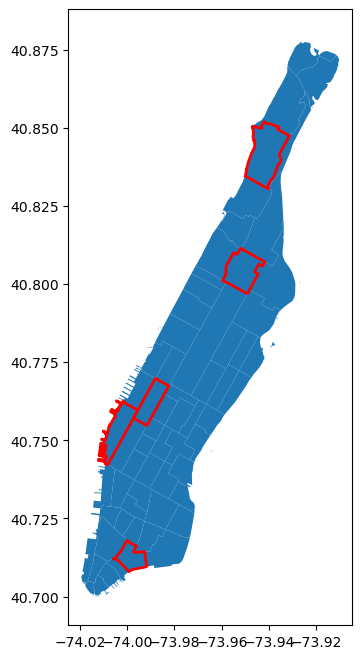

In [57]:
highlight_ids = [zone_id[i-1] for i in [5,8,9,58,59]]
highlighted_data = zones_wgs84[zones_wgs84['LocationID'].isin(highlight_ids)]

fig, ax = plt.subplots(figsize=(12, 8))

zones_wgs84[zones_wgs84['LocationID'].isin(zone_id)].plot(ax=ax)
highlighted_data.plot(ax = ax, facecolor='none', edgecolor='red', linewidth=2)